In [6]:
import autograd.numpy as np
from autograd import grad
import scipy.optimize as sop
import pyute as ut
import matplotlib.pyplot as plt

def pred_distance_effect(D,amplitudeE,sigmaE,amplitudeI,sigmaI,fudge=1e-3):
    # D: Nn non-target neurons x Ne ensembles x Nt targeted neurons/ensemble
    def gaussian(x,amplitude,sigma):
        s2 = sigma**2+fudge
        return amplitude*np.exp(-0.5*x**2/s2)/np.sqrt(2*np.pi*s2)
    Eeffect = np.sum(gaussian(D,amplitudeE,sigmaE),axis=-1)
    Ieffect = np.sum(gaussian(D,amplitudeI,sigmaI),axis=-1)
    return Eeffect - Ieffect

def fit_distance_kernel(D,dF):
    # D: Nn non-target neurons x Ne ensembles x Nt targeted neurons/ensemble
    # dF: Nn non-target neurons x Ne ensembles
    def cost(theta):
        modeled = pred_distance_effect(D,*theta)
        return np.sum((dF - modeled)**2)
    theta0 = np.array((1,100,1,100))
    bds = sop.Bounds(lb=np.zeros_like(theta0),ub=np.inf*np.ones_like(theta0))
    res = sop.minimize(cost,theta0,bounds=bds,jac=grad(cost))
    if res.success:
        return res.x
    else:
        return np.nan*np.ones_like(res.x)

In [2]:
noise = 0.1
Nn = 100
Ne = 50
Nt = 20
Nrep = 100
D = 500*np.random.rand(Nn,Ne,Nt)
theta_actual = np.array((1,50,3,200))
theta_fit = np.zeros((Nrep,4))
for irep in range(Nrep):
    modeled_data = pred_distance_effect(D,*theta_actual) + noise*np.random.randn(Nn,Ne)
    theta_fit[irep] = fit_distance_kernel(D,modeled_data)

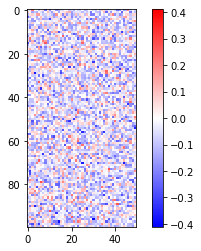

In [7]:
plt.figure()
ut.imshow_hot_cold(modeled_data)
plt.colorbar()

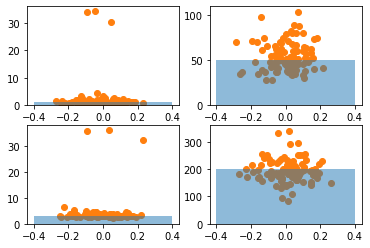

In [8]:
eps = 0.1
plt.figure()
for iparam in range(4):
    plt.subplot(2,2,iparam+1)
    plt.bar(0,theta_actual[iparam],alpha=0.5)
    plt.scatter(np.zeros((theta_fit.shape[0],))+eps*np.random.randn(theta_fit.shape[0]),theta_fit[:,iparam])